In [1]:
from platform import python_version
print(python_version())

3.8.10


In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
import numpy as np
from tqdm import tqdm
import h5py
import cv2
import os
import shutil
import itertools
import imutils
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
from plotly import tools

from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16, preprocess_input
from keras import layers
from keras.models import Model, Sequential
from keras.optimizers import Adam, RMSprop
from keras.callbacks import EarlyStopping
init_notebook_mode(connected=True)
RANDOM_SEED = 123
print("ok")

ok


In [4]:
#!apt-get install tree
#clear_output()

# Creamos las carpetas que contendrán las imagenes de entrenamiento
!mkdir TRAIN TEST VAL TRAIN/YES TRAIN/NO TEST/YES TEST/NO VAL/YES VAL/NO

#!tree -D

### Esta función nos permite duplicar el dataset, a partir de aplicarle una pequeña rotación a las imagenes

In [32]:
def duplicate_img_rotate(directory, angle):
    #Aplicamos rotación a las imagenes y las duplicamos para aumentar el tamaño del dataset
    scale = 1
    for filename in os.listdir(directory):
        img = cv2.imread(os.path.join(directory, filename))
        rotation_matrix = cv2.getRotationMatrix2D((img.shape[1]/2, img.shape[0]/2), angle, scale)
        rotated_img = cv2.warpAffine(img, rotation_matrix, (img.shape[1], img.shape[0]))
        rotated_filename =  "rotated_" + filename
        cv2.imwrite(os.path.join(directory, rotated_filename), rotated_img)

#duplicamos los datasets
IMAGES_PATH = "/content/drive/MyDrive/Examen_ML/brain_tumor_dataset/no/"
duplicate_img_rotate(IMAGES_PATH, 30)
IMAGES_PATH = "/content/drive/MyDrive/Examen_ML/brain_tumor_dataset/yes/"
duplicate_img_rotate(IMAGES_PATH, 30)

In [33]:
import os
IMG_PATH = "/content/drive/MyDrive/Examen_ML/brain_tumor_dataset/"
# Divide las imagenes del dataset original en train/val/test
for CLASS in os.listdir(IMG_PATH):
   #if os.path.isdir(CLASS):
    if (os.path.isfile(CLASS)==False) and (CLASS=="yes" or CLASS=="no"):
        print(CLASS)
        IMG_NUM = len(os.listdir(IMG_PATH + CLASS))
        print(IMG_NUM)
        for (n, FILE_NAME) in enumerate(os.listdir(IMG_PATH + CLASS)):
            img = IMG_PATH + CLASS + '/' + FILE_NAME
            print(img)
            if n < 25:
                shutil.copy(img, 'TEST/' + CLASS.upper() + '/' + FILE_NAME)
                print("TO TEST")
            elif n < 0.8*IMG_NUM:
                shutil.copy(img, 'TRAIN/'+ CLASS.upper() + '/' + FILE_NAME)
                print("TO TRAIN")
            else:
                shutil.copy(img, 'VAL/'+ CLASS.upper() + '/' + FILE_NAME)
                print("TO VAL")


yes
465
/content/drive/MyDrive/Examen_ML/brain_tumor_dataset/yes/Y77.jpg
TO TEST
/content/drive/MyDrive/Examen_ML/brain_tumor_dataset/yes/Y102.jpg
TO TEST
/content/drive/MyDrive/Examen_ML/brain_tumor_dataset/yes/Y14.jpg
TO TEST
/content/drive/MyDrive/Examen_ML/brain_tumor_dataset/yes/Y31.jpg
TO TEST
/content/drive/MyDrive/Examen_ML/brain_tumor_dataset/yes/Y258.JPG
TO TEST
/content/drive/MyDrive/Examen_ML/brain_tumor_dataset/yes/Y61.jpg
TO TEST
/content/drive/MyDrive/Examen_ML/brain_tumor_dataset/yes/Y52.jpg
TO TEST
/content/drive/MyDrive/Examen_ML/brain_tumor_dataset/yes/Y8.jpg
TO TEST
/content/drive/MyDrive/Examen_ML/brain_tumor_dataset/yes/Y30.jpg
TO TEST
/content/drive/MyDrive/Examen_ML/brain_tumor_dataset/yes/Y9.jpg
TO TEST
/content/drive/MyDrive/Examen_ML/brain_tumor_dataset/yes/Y99.JPG
TO TEST
/content/drive/MyDrive/Examen_ML/brain_tumor_dataset/yes/Y16.JPG
TO TEST
/content/drive/MyDrive/Examen_ML/brain_tumor_dataset/yes/Y120.JPG
TO TEST
/content/drive/MyDrive/Examen_ML/brain_tum

In [34]:
def load_data(dir_path, img_size=(100,100)):
    #Carga las imagebes como np.arrays y les cambia el tamaño
    X = []
    y = []
    i = 0
    labels = dict()
    for path in tqdm(sorted(os.listdir(dir_path))):
        if not path.startswith('.'):
            labels[i] = path
            for file in os.listdir(dir_path + path):
                if not file.startswith('.'):
                    img = cv2.imread(dir_path + path + '/' + file)
                    X.append(img)
                    y.append(i)
            i += 1
    X = np.array(X,dtype=object)
    y = np.array(y)
    print(f'{len(X)} imagenes cargadas desde: {dir_path}.')
    return X, y, labels



def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    Esta funcion imprime y plotea la matriz de confucion.
    Se puede aplicar Normalization haciendo `normalize=True`.
    """
    plt.figure(figsize = (6,6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    cm = np.round(cm,2)
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [35]:
TRAIN_DIR = 'TRAIN/'
TEST_DIR = 'TEST/'
VAL_DIR = 'VAL/'
IMG_SIZE = (224,224)

# Cargamos cada uno de los conjuntos de imagener entrenamiento
# prueba y validación
X_train, y_train, labels = load_data(TRAIN_DIR, IMG_SIZE)
print(labels)
X_test, y_test, _ = load_data(TEST_DIR, IMG_SIZE)
X_val, y_val, _ = load_data(VAL_DIR, IMG_SIZE)

100%|██████████| 2/2 [00:01<00:00,  1.40it/s]


558 imagenes cargadas desde: TRAIN/.
{0: 'NO', 1: 'YES'}


100%|██████████| 2/2 [00:00<00:00, 23.24it/s]


50 imagenes cargadas desde: TEST/.


100%|██████████| 2/2 [00:00<00:00,  2.88it/s]

252 imagenes cargadas desde: VAL/.


In [36]:
def plot_samples(X, y, labels_dict, n=50):
    """
    Crea un gridplot para mostrar un número deseado de imágenes  
    """
    for index in range(len(labels_dict)):
        imgs = X[np.argwhere(y == index)][:n]
        j = 10
        i = int(n/j)

        plt.figure(figsize=(15,6))
        c = 1
        for img in imgs:
            plt.subplot(i,j,c)
            plt.imshow(img[0])

            plt.xticks([])
            plt.yticks([])
            c += 1
        plt.suptitle('Tumor: {}'.format(labels_dict[index]))
        plt.show()

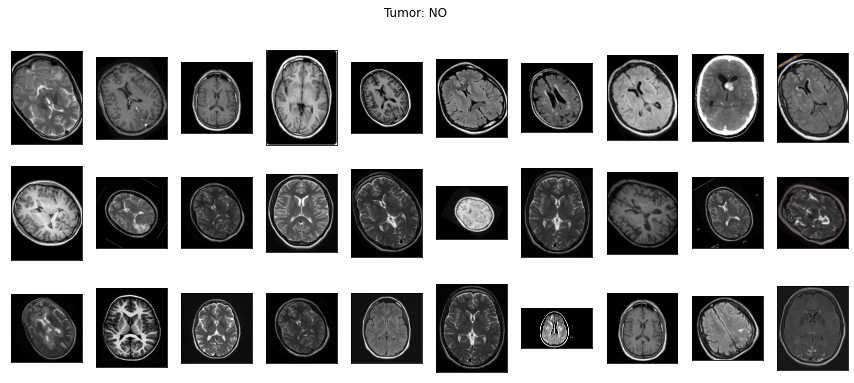

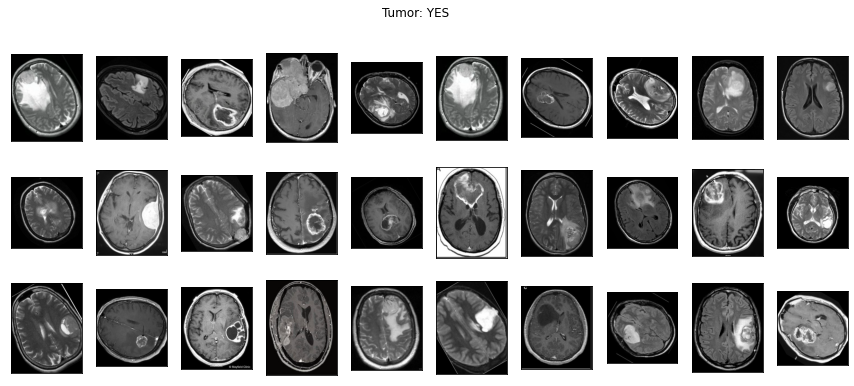

In [37]:
plot_samples(X_train, y_train, labels, 30)

In [38]:
# Homomorphic filter class
class HomomorphicFilter:
    """Homomorphic filter implemented with diferents filters and an option to an external filter.
    
    High-frequency filters implemented:
        butterworth
        gaussian
    Attributes:
        a, b: Floats used on emphasis filter:
            H = a + b*H
     
       .
    """

    def __init__(self, a = 0.5, b = 1.5):
        self.a = float(a)
        self.b = float(b)

    # Filters
    def __butterworth_filter(self, I_shape, filter_params):
        P = I_shape[0]/2
        Q = I_shape[1]/2
        U, V = np.meshgrid(range(I_shape[0]), range(I_shape[1]), sparse=False, indexing='ij')
        Duv = (((U-P)**2+(V-Q)**2)).astype(float)
        H = 1/(1+(Duv/filter_params[0]**2)**filter_params[1])
        return (1 - H)

    def __gaussian_filter(self, I_shape, filter_params):
        P = I_shape[0]/2
        Q = I_shape[1]/2
        H = np.zeros(I_shape)
        U, V = np.meshgrid(range(I_shape[0]), range(I_shape[1]), sparse=False, indexing='ij')
        Duv = (((U-P)**2+(V-Q)**2)).astype(float)
        H = np.exp((-Duv/(2*(filter_params[0])**2)))
        return (1 - H)

    # Methods
    def __apply_filter(self, I, H):
        H = np.fft.fftshift(H)
        I_filtered = (self.a + self.b*H)*I
        return I_filtered

    def filter(self, I, filter_params, filter='butterworth', H = None):
        """
        Method to apply homormophic filter on an image
        Attributes:
            I: Single channel image
            filter_params: Parameters to be used on filters:
                butterworth:
                    filter_params[0]: Cutoff frequency 
                    filter_params[1]: Order of filter
                gaussian:
                    filter_params[0]: Cutoff frequency
            filter: Choose of the filter, options:
                butterworth
                gaussian
                external
            H: Used to pass external filter
        """

        #  Validating image
        if len(I.shape) != 2:
            raise Exception('Improper image')

        # Take the image to log domain and then to frequency domain 
        I_log = np.log1p(np.array(I, dtype="float"))
        I_fft = np.fft.fft2(I_log)

        # Filters
        if filter=='butterworth':
            H = self.__butterworth_filter(I_shape = I_fft.shape, filter_params = filter_params)
        elif filter=='gaussian':
            H = self.__gaussian_filter(I_shape = I_fft.shape, filter_params = filter_params)
        elif filter=='external':
            print('external')
            if len(H.shape) != 2:
                raise Exception('Invalid external filter')
        else:
            raise Exception('Selected filter not implemented')
        
        # Apply filter on frequency domain then take the image back to spatial domain
        I_fft_filt = self.__apply_filter(I = I_fft, H = H)
        I_filt = np.fft.ifft2(I_fft_filt)
        I = np.exp(np.real(I_filt))-1
        return np.uint8(I)
# End of class HomomorphicFilter

In [39]:
def crop_imgs(set_name, add_pixels_value=0):
    """
    Encuentra los puntos extremos de la imagen y la corta de forma rectangular
    """
    set_new = []
    for img in set_name:
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        gray = cv2.GaussianBlur(gray, (5, 5), 0)

        # threshold the image, then perform a series of erosions +
        # dilations to remove any small regions of noise
        thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
        thresh = cv2.erode(thresh, None, iterations=2)
        thresh = cv2.dilate(thresh, None, iterations=2)

        # find contours in thresholded image, then grab the largest one
        cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cnts = imutils.grab_contours(cnts)
        c = max(cnts, key=cv2.contourArea)

        # find the extreme points
        extLeft = tuple(c[c[:, :, 0].argmin()][0])
        extRight = tuple(c[c[:, :, 0].argmax()][0])
        extTop = tuple(c[c[:, :, 1].argmin()][0])
        extBot = tuple(c[c[:, :, 1].argmax()][0])

        ADD_PIXELS = add_pixels_value
        new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()
        new_img = cv2.cvtColor(new_img, cv2.COLOR_RGB2GRAY)
        homo_filter = HomomorphicFilter(a = 0.9, b = 1.4)
        new_img = homo_filter.filter(I=new_img, filter_params=[30,2])
        new_img = cv2.equalizeHist(new_img)
        new_img = cv2.cvtColor(new_img,cv2.COLOR_GRAY2RGB)
        set_new.append(new_img)

    return np.array(set_new, dtype=object)

In [40]:
# Aplicamos a cada uno de los subconjuntos
X_train_crop = crop_imgs(set_name=X_train)
X_val_crop = crop_imgs(set_name=X_val)
X_test_crop = crop_imgs(set_name=X_test)

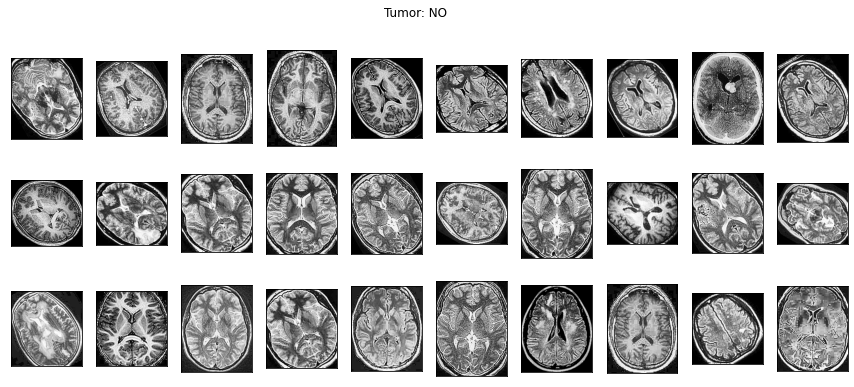

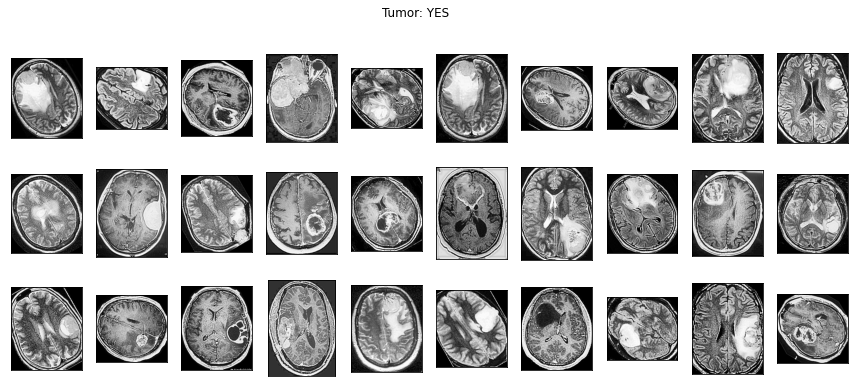

In [41]:
plot_samples(X_train_crop, y_train, labels, 30)

In [42]:
def save_new_images(x_set, y_set, folder_name):
    i = 0
    for (img, imclass) in zip(x_set, y_set):
        if imclass == 0:
            cv2.imwrite(folder_name+'NO/'+str(i)+'.jpg', img)
        else:
            cv2.imwrite(folder_name+'YES/'+str(i)+'.jpg', img)
        i += 1

In [43]:
# Creamos las carpetas donde guardaremos las imagenes
!mkdir TRAIN_CROP TEST_CROP VAL_CROP TRAIN_CROP/YES 
!mkdir TRAIN_CROP/NO TEST_CROP/YES TEST_CROP/NO VAL_CROP/YES 
!mkdir VAL_CROP/NO

# Guardamos las imagenes que recortamos en las carpetas anteriores
save_new_images(X_train_crop, y_train, folder_name='TRAIN_CROP/')
save_new_images(X_val_crop, y_val, folder_name='VAL_CROP/')
save_new_images(X_test_crop, y_test, folder_name='TEST_CROP/')

mkdir: cannot create directory ‘TRAIN_CROP’: File exists
mkdir: cannot create directory ‘TEST_CROP’: File exists
mkdir: cannot create directory ‘VAL_CROP’: File exists
mkdir: cannot create directory ‘TRAIN_CROP/YES’: File exists
mkdir: cannot create directory ‘TRAIN_CROP/NO’: File exists
mkdir: cannot create directory ‘TEST_CROP/YES’: File exists
mkdir: cannot create directory ‘TEST_CROP/NO’: File exists
mkdir: cannot create directory ‘VAL_CROP/YES’: File exists
mkdir: cannot create directory ‘VAL_CROP/NO’: File exists


In [44]:
def preprocess_imgs(set_name, img_size):
    """
    Resiza y aplica preprocesamiento VGG-15
    """
    set_new = []
    for img in set_name:
        img = cv2.resize(
            img,
            dsize=img_size,
            #fx=1/255., 
            #fy=1/255.,
            interpolation=cv2.INTER_CUBIC
        )
        set_new.append(preprocess_input(img))
    return np.array(set_new)

In [45]:
X_train_prep = preprocess_imgs(set_name=X_train_crop, img_size=IMG_SIZE)
X_test_prep = preprocess_imgs(set_name=X_test_crop, img_size=IMG_SIZE)
X_val_prep = preprocess_imgs(set_name=X_val_crop, img_size=IMG_SIZE)

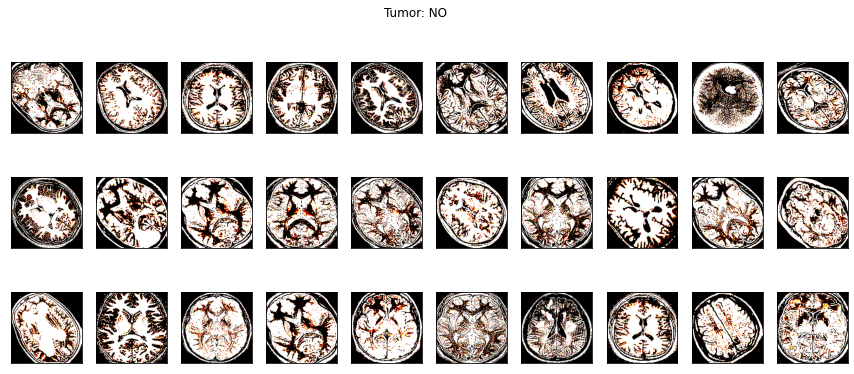

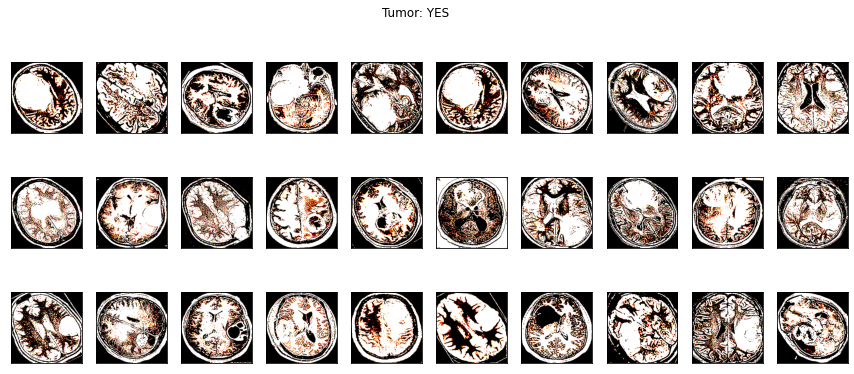

In [46]:

plot_samples(X_train_prep, y_train, labels, 30)

In [47]:
TRAIN_DIR = 'TRAIN_CROP/'
VAL_DIR = 'VAL_CROP/'

train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    brightness_range=[0.5, 1.5],
    horizontal_flip=True,
    vertical_flip=True,
    preprocessing_function=preprocess_input
)

test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    color_mode='rgb',
    target_size=IMG_SIZE,
    batch_size=32,
    class_mode='binary',
    seed=RANDOM_SEED
)

validation_generator = test_datagen.flow_from_directory(
    VAL_DIR,
    color_mode='rgb',
    target_size=IMG_SIZE,
    batch_size=16,
    class_mode='binary',
    seed=RANDOM_SEED
)

Found 637 images belonging to 2 classes.
Found 310 images belonging to 2 classes.


### Entrenar modelo VGG19

In [22]:
import tensorflow
import keras
from keras.layers import Concatenate
from keras.callbacks import ModelCheckpoint
from keras.applications import ResNet50, DenseNet201, VGG16, InceptionV3
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Dense, LSTM, Flatten, BatchNormalization, MaxPooling2D, Conv2D, Reshape, UpSampling2D, GlobalAveragePooling2D
from keras.models import Model


EPOCHS = 100
NUM_CLASSES = 1


metrics = [
    keras.metrics.TruePositives(name='tp'),
    keras.metrics.FalsePositives(name='fp'),
    keras.metrics.TrueNegatives(name='tn'),
    keras.metrics.FalseNegatives(name='fn'), 
    keras.metrics.BinaryAccuracy(name='accuracy'),
    keras.metrics.Precision(name='precision'),
    keras.metrics.Recall(name='recall'),
    keras.metrics.AUC(name='auc'),
    keras.metrics.AUC(name='prc', curve='PR')
]

# es = EarlyStopping(
#    monitor='val_accuracy', 
#    mode='max',
#    patience=20,
#    restore_best_weights=True
# )

reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='accuracy', factor=0.3, patience=5, min_lr=0.0000001)

checkpoint = ModelCheckpoint(filepath='model_vgg19.h5', 
   monitor='val_accuracy', 
   mode='max', 
   save_best_only=True, 
   verbose=1)

keras.backend.clear_session()
input_shape = (224, 224, 3)

base_model = keras.applications.vgg19.VGG19(
    weights='imagenet', 
    include_top=False,
    input_shape=input_shape
)
base_model.trainable = False

model_vgg19 = Sequential()
model_vgg19.add(base_model)
model_vgg19.add(Flatten())
model_vgg19.add(layers.Dropout(0.2))
model_vgg19.add(Dense(NUM_CLASSES, activation='sigmoid'))
model_vgg19.compile(loss='binary_crossentropy', optimizer=Adam(0.01), metrics=metrics)
model_vgg19.summary()


history_vgg19 = model_vgg19.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=validation_generator,
    callbacks=[checkpoint, reduce_lr]
)



80134624/80134624 [==============================] - 3s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dropout (Dropout)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 1)                 25089     
                                                                 
Total params: 20,049,473
Trainable params: 25,089
Non-trainable params: 20,024,384
_________________________________________________________________
Epoch 1/100
12/12 [==============================] - ETA: 0s - loss: 27.3174 - tp: 158.0000 - fp: 55.0000 

### Entrenar un Random Forest con las predicciones de VGG19


***Accuracy VGG19 with Random Forest***
2/2 [==============================] - 0s 215ms/step
Precision: 0.8621, Recall: 1.0000, F1-score: 0.9259


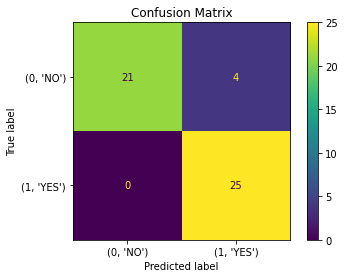

In [103]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import precision_recall_fscore_support
import matplotlib.pyplot as plt

print("\n***Accuracy VGG19 with Random Forest***")

model_vgg19 = keras.models.load_model('model_vgg19.h5')

# Crear una instancia del modelo de Random Forest
rf = RandomForestClassifier(n_estimators=100, criterion='gini', max_depth=5)

# Obtener las predicciones del modelo existente
y_pred = model_vgg19.predict(X_test_prep)

# Entrenar el modelo de Random Forest con las predicciones del modelo existente y las etiquetas de prueba
rf.fit(y_pred, y_test)

y_pred_prob = rf.predict_proba(y_pred)

# Redondear las probabilidades de clase predichas
y_pred_prob_round = np.argmax(y_pred_prob, axis=1)
# y_pred_prob_round = [1 if x>=0.5 else 0 for x in y_pred_prob]

precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred_prob_round, average='binary')
print(f'Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}')

# Calcular la matriz de confusión
confusion_mtx = confusion_matrix(y_test, y_pred_prob_round)

# Mostrar el gráfico de matriz de confusión
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_mtx, display_labels=list(labels.items())).plot()
disp.ax_.set_title("Confusion Matrix")
plt.show()

###### Como se puede observar, no existe mejora en los resultados aplicando un random forest

### Entrenar modelo InceptionV3

In [52]:
import tensorflow
import keras
from keras.layers import Concatenate
from keras.callbacks import ModelCheckpoint
from keras.applications import ResNet50, DenseNet201, VGG16, InceptionV3
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Dense, LSTM, Flatten, BatchNormalization, MaxPooling2D, Conv2D, Reshape, UpSampling2D, GlobalAveragePooling2D
from keras.models import Model


EPOCHS = 100
NUM_CLASSES = 1

metrics = [
    keras.metrics.TruePositives(name='tp'),
    keras.metrics.FalsePositives(name='fp'),
    keras.metrics.TrueNegatives(name='tn'),
    keras.metrics.FalseNegatives(name='fn'), 
    keras.metrics.BinaryAccuracy(name='accuracy'),
    keras.metrics.Precision(name='precision'),
    keras.metrics.Recall(name='recall'),
    keras.metrics.AUC(name='auc'),
    keras.metrics.AUC(name='prc', curve='PR')
]

checkpoint = ModelCheckpoint(filepath='model_inceptionv3.h5', 
   monitor='val_accuracy', 
   mode='max', 
   save_best_only=True, 
   verbose=1)

reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='accuracy', factor=0.1, patience=5, min_lr=0.0000001)

keras.backend.clear_session()
input_shape = (224, 224, 3)

base_model = keras.applications.InceptionV3(
    weights='imagenet', 
    include_top=False, 
    input_shape=input_shape
)
base_model.trainable = False
model_inceptionv3 = Sequential()
model_inceptionv3.add(base_model)
model_inceptionv3.add(Flatten())
model_inceptionv3.add(layers.Dropout(0.5))
model_inceptionv3.add(Dense(NUM_CLASSES, activation='sigmoid'))
model_inceptionv3.compile(loss='binary_crossentropy', optimizer=Adam(0.01), metrics=metrics)
model_inceptionv3.summary()

history_inceptionv3 = model_inceptionv3.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=validation_generator,
    callbacks=[checkpoint, reduce_lr]
)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 flatten (Flatten)           (None, 51200)             0         
                                                                 
 dropout (Dropout)           (None, 51200)             0         
                                                                 
 dense (Dense)               (None, 1)                 51201     
                                                                 
Total params: 21,853,985
Trainable params: 51,201
Non-trainable params: 21,802,784
_________________________________________________________________
Epoch 1/100
20/20 [==============================] - ETA: 0s - loss: 212.6694 - tp: 303.0000 - fp: 145.0000 - tn: 66.0000 - fn: 123.0000 - accuracy: 0.5793 - precision: 0.

### Entrenar modelo U-Net

In [104]:
!pip install keras_unet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [105]:
import tensorflow
import keras
from keras.layers import Concatenate
from keras.callbacks import ModelCheckpoint
from keras.applications import ResNet50, DenseNet201, VGG16, InceptionV3
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Dense, LSTM, Flatten, BatchNormalization, MaxPooling2D, Conv2D, Reshape, UpSampling2D, GlobalAveragePooling2D
from keras.models import Model
from keras_unet.models import custom_unet


EPOCHS = 100
NUM_CLASSES = 1
batch_size=64
val_batch_size=16

metrics = [
    keras.metrics.TruePositives(name='tp'),
    keras.metrics.FalsePositives(name='fp'),
    keras.metrics.TrueNegatives(name='tn'),
    keras.metrics.FalseNegatives(name='fn'), 
    keras.metrics.BinaryAccuracy(name='accuracy'),
    keras.metrics.Precision(name='precision'),
    keras.metrics.Recall(name='recall'),
    keras.metrics.AUC(name='auc'),
    keras.metrics.AUC(name='prc', curve='PR')
]

# es = EarlyStopping(
#    monitor='val_accuracy', 
#    mode='max',
#    patience=20,
#    restore_best_weights=True
# )

checkpoint = ModelCheckpoint(filepath='model_unet.h5', 
   monitor='val_accuracy', 
   mode='max', 
   save_best_only=True, 
   verbose=1)


keras.backend.clear_session()
input_shape = (224, 224, 3)

# create the model
base_model = custom_unet(input_shape=input_shape, use_batch_norm=True, num_classes=1)

base_model.trainable = False

model_unet = Sequential()
model_unet.add(base_model)
model_unet.add(Flatten())
model_unet.add(layers.Dropout(0.2))
model_unet.add(Dense(NUM_CLASSES, activation='sigmoid'))
model_unet.compile(loss='binary_crossentropy', optimizer=Adam(0.01), metrics=metrics)
model_unet.summary()


history_unet = model_unet.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=validation_generator,
    callbacks=[checkpoint]
)



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model (Functional)          (None, 224, 224, 1)       1945521   
                                                                 
 flatten (Flatten)           (None, 50176)             0         
                                                                 
 dropout (Dropout)           (None, 50176)             0         
                                                                 
 dense (Dense)               (None, 1)                 50177     
                                                                 
Total params: 1,995,698
Trainable params: 50,177
Non-trainable params: 1,945,521
_________________________________________________________________
Epoch 1/100
20/20 [==============================] - ETA: 0s - loss: 16.7576 - tp: 261.0000 - fp: 134.0000 - tn: 77.0000 - fn: 165.0000 - accuracy: 0.5306 - precision: 0.660

### Entrenar modelo DenseNet

In [106]:
import tensorflow
import keras
from keras.layers import Concatenate
from keras.callbacks import ModelCheckpoint
from keras.applications import ResNet50, DenseNet201, VGG16, InceptionV3
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Dense, LSTM, Flatten, BatchNormalization, MaxPooling2D, Conv2D, Reshape, UpSampling2D, GlobalAveragePooling2D
from keras.models import Model
from keras_unet.models import custom_unet



EPOCHS = 100
NUM_CLASSES = 1
batch_size=32
val_batch_size=16


metrics = [
    keras.metrics.TruePositives(name='tp'),
    keras.metrics.FalsePositives(name='fp'),
    keras.metrics.TrueNegatives(name='tn'),
    keras.metrics.FalseNegatives(name='fn'), 
    keras.metrics.BinaryAccuracy(name='accuracy'),
    keras.metrics.Precision(name='precision'),
    keras.metrics.Recall(name='recall'),
    keras.metrics.AUC(name='auc'),
    keras.metrics.AUC(name='prc', curve='PR')
]

# es = EarlyStopping(
#    monitor='val_accuracy', 
#    mode='max',
#    patience=20,
#    restore_best_weights=True
# )

checkpoint = ModelCheckpoint(filepath='model_densenet.h5', 
   monitor='val_accuracy', 
   mode='max', 
   save_best_only=True, 
   verbose=1)


keras.backend.clear_session()
input_shape = (224, 224, 3)

# create the model
base_model = keras.applications.inception_resnet_v2.InceptionResNetV2(
    weights='imagenet', 
    include_top=False,
    input_shape=input_shape
)
base_model.trainable = False

model_densenet = Sequential()
model_densenet.add(base_model)
model_densenet.add(Flatten())
model_densenet.add(layers.Dropout(0.2))
model_densenet.add(Dense(NUM_CLASSES, activation='sigmoid'))
model_densenet.compile(loss='binary_crossentropy', optimizer=Adam(0.01), metrics=metrics)
model_densenet.summary()


history_densenet = model_densenet.fit(
    train_generator,
    #steps_per_epoch=len(X_train)//batch_size,
    epochs=EPOCHS,
    validation_data=validation_generator,
    #validation_steps=len(X_test)//val_batch_size,
    callbacks=[checkpoint]#, es]
)



219055592/219055592 [==============================] - 6s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_resnet_v2 (Functi  (None, 5, 5, 1536)       54336736  
 onal)                                                           
                                                                 
 flatten (Flatten)           (None, 38400)             0         
                                                                 
 dropout (Dropout)           (None, 38400)             0         
                                                                 
 dense (Dense)               (None, 1)                 38401     
                                                                 
Total params: 54,375,137
Trainable params: 38,401
Non-trainable params: 54,336,736
_________________________________________________________________
Epoch 1/100
20/20 [===================

### Evaluar modelos

In [107]:
model_inceptionv3 = keras.models.load_model('model_inceptionv3.h5')
# loss, accuracy = model_inceptionv3.evaluate(X_test_prep, y_test)
# print("Accuracy InceptionV3: {}".format(accuracy))
y_pred = model_inceptionv3.predict(X_test_prep)
y_pred = [1 if x>0.5 else 0 for x in y_pred]
print("Accuracy InceptionV3: {}".format(accuracy_score(y_test, y_pred)))

model_vgg19 = keras.models.load_model('model_vgg19.h5')
# loss, accuracy = model_vgg19.evaluate(X_test_prep, y_test)
# print("Accuracy VGG19: {}".format(accuracy))
y_pred = model_vgg19.predict(X_test_prep)
y_pred = [1 if x>0.5 else 0 for x in y_pred]
print("Accuracy VGG19: {}".format(accuracy_score(y_test, y_pred)))

model_unet = keras.models.load_model('model_unet.h5')
# loss, accuracy = model_unet.evaluate(X_test_prep, y_test)
# print("Accuracy U-Net: {}".format(accuracy))
y_pred = model_unet.predict(X_test_prep)
y_pred = [1 if x>0.5 else 0 for x in y_pred]
print("Accuracy U-Net: {}".format(accuracy_score(y_test, y_pred)))

model_densenet = keras.models.load_model('model_densenet.h5')
# loss, accuracy = model_densenet.evaluate(X_test_prep, y_test)
# print("Accuracy DenseNet: {}".format(accuracy))
y_pred = model_densenet.predict(X_test_prep)
y_pred = [1 if x>0.5 else 0 for x in y_pred]
print("Accuracy DenseNet: {}".format(accuracy_score(y_test, y_pred)))


2/2 [==============================] - 2s 1s/step
Accuracy InceptionV3: 0.78
2/2 [==============================] - 0s 178ms/step
Accuracy VGG19: 0.92
2/2 [==============================] - 1s 831ms/step
Accuracy U-Net: 0.56
2/2 [==============================] - 4s 851ms/step
Accuracy DenseNet: 0.68


### Curve ROC (Precision-Recall)

2/2 [==============================] - 0s 178ms/step
Best Threshold=0.999613, G-Mean=0.917


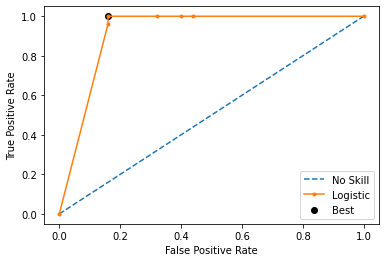

In [108]:
from numpy import argmax
from numpy import sqrt
from sklearn.metrics import roc_curve, brier_score_loss
from matplotlib import pyplot

model = model_vgg19

# Roc curve version with threshold
y_pred = model.predict(X_test_prep)
#y_pred = [1 if x>0.5 else 0 for x in y_pred]

# calculate roc curves
fpr, tpr, thresholds = roc_curve(y_test.ravel(), y_pred.ravel())

# calculate the g-mean for each threshold
gmeans = sqrt(tpr * (1-fpr))

# locate the index of the largest g-mean
ix = argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))
threshold = thresholds[ix]

#calculate brier_score_loss
#score_loss = brier_score_loss(y_test.ravel(), y_pred.ravel())
#print(score_loss)

# plot the roc curve for the model
pyplot.plot([0,1], [0,1], linestyle='--', label='No Skill')
pyplot.plot(fpr, tpr, marker='.', label='Logistic')
pyplot.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()
# show the plot
pyplot.show()

### Evaluate model with threshold

In [109]:
y_pred = model.predict(X_test_prep)
y_pred = [1 if x >= threshold else 0 for x in y_pred]
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: {}".format(accuracy))

2/2 [==============================] - 0s 178ms/step
Accuracy: 0.92


### Gráficas historial

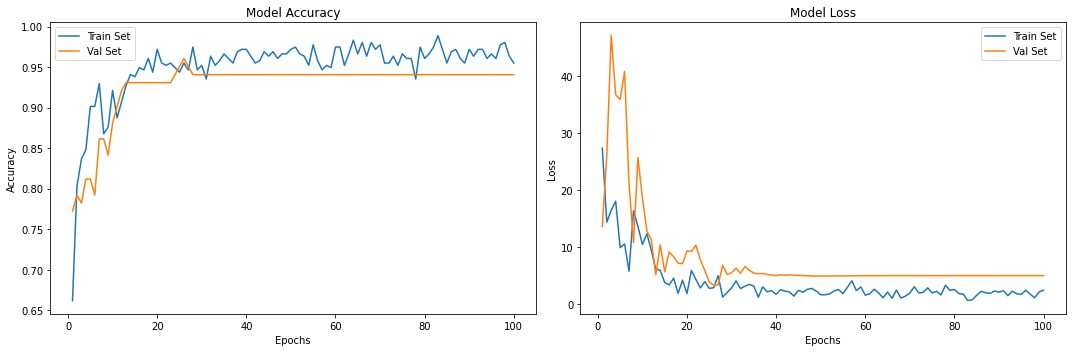

In [110]:
import pandas as pd

history = history_vgg19

# plot model performance
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(history.epoch) + 1)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')

plt.tight_layout()
plt.show()

### Matriz de confusión con set de validación

8/8 [==============================] - 1s 185ms/step
Val Accuracy = 0.81


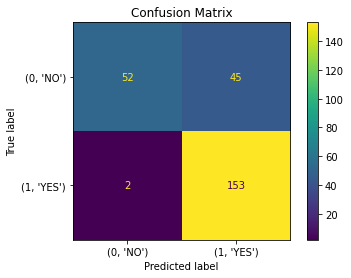

In [121]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

# validate on val set
predictions = model.predict(X_val_prep)
predictions = [1 if x>0.5 else 0 for x in predictions]

accuracy = accuracy_score(y_val, predictions)
print('Val Accuracy = %.2f' % accuracy)

# Calcular la matriz de confusión
confusion_mtx = confusion_matrix(y_val, predictions)

# Mostrar el gráfico de matriz de confusión
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_mtx, display_labels=list(labels.items())).plot()
disp.ax_.set_title("Confusion Matrix")
plt.show()

In [122]:
from sklearn.metrics import classification_report

print('\nClassification report:\n',classification_report(predictions, y_val))


Classification report:
               precision    recall  f1-score   support

           0       0.54      0.96      0.69        54
           1       0.99      0.77      0.87       198

    accuracy                           0.81       252
   macro avg       0.76      0.87      0.78       252
weighted avg       0.89      0.81      0.83       252



### Matriz de confusión con set de prueba

2/2 [==============================] - 0s 226ms/step
Test Accuracy = 0.92


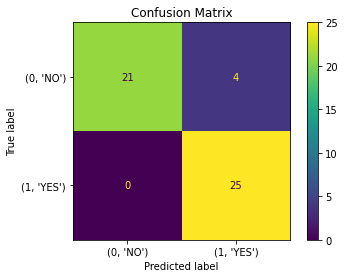

In [123]:
# validate on test set
predictions = model.predict(X_test_prep)
predictions = [1 if x>0.5 else 0 for x in predictions]

accuracy = accuracy_score(y_test, predictions)
print('Test Accuracy = %.2f' % accuracy)

confusion_mtx = confusion_matrix(y_test, predictions)
# Mostrar el gráfico de matriz de confusión
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_mtx, display_labels=list(labels.items())).plot()
disp.ax_.set_title("Confusion Matrix")
plt.show()

In [124]:
from sklearn.metrics import classification_report

print('\nClassification report:\n',classification_report(predictions, y_test))


Classification report:
               precision    recall  f1-score   support

           0       0.84      1.00      0.91        21
           1       1.00      0.86      0.93        29

    accuracy                           0.92        50
   macro avg       0.92      0.93      0.92        50
weighted avg       0.93      0.92      0.92        50



### Guardar en archivo comprimido el modelo

In [ ]:
import tensorflow as tf
import zipfile
# clean up the space
!rm -rf TRAIN TEST VAL TRAIN_CROP TEST_CROP VAL_CROP
# save the model
model.save('2023-01-26_VGG19_model.h5')
#Para salvar el modelo en formato protobuf
Version="202301260001"
model_path=os.getcwd()
export_path=os.path.join(model_path,Version)
tf.saved_model.save(model,export_path)
modelZiped=zipfile.ZipFile("modelZiped.zip","w")
for folder, subfolders, files in os.walk(export_path):
     for file in files:
            modelZiped.write(os.path.join(folder, file), os.path.relpath(os.path.join(folder,file), ''), 
                             compress_type = zipfile.ZIP_DEFLATED)
modelZiped.close()
